In [299]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from collections import defaultdict

In [285]:
def addToDict(team, win, a, b, periods):
    a = dict(a)
    b = dict(b)
    a['team'] = team
    a['win'] = win
    for i in range(1, max(periods + 1)):
        if i in a.keys():
            a[i] = 60*int(a[i][3:5]) + int(a[i][6:])
        if i in b.keys():
            a[-i] = 60*int(b[i][3:5]) + int(b[i][6:])
    return a
        
def bonusTime(dfIn):
    teams = dfIn['team'].dropna().unique()
    periods =  dfIn['period'].dropna().unique()
    final = dict(dfIn.groupby('team').sum()['points'].iteritems())
    
    df = dfIn#[dfIn['period']<=4]
    df['Total Fouls'] = df[df['event_type']=='foul']['description'].fillna('123').apply(lambda x: x[-3:-1])
    bTimes = df[(df['event_type'] == 'foul') & (df['Total Fouls'] == 'PN')][['period','remaining_time','team']].groupby('team')
    
    bonuses= []
    for team in teams:
        opp = list(set(teams) - set([team]))[0]
        try:
            a = bTimes.get_group(opp).groupby('period')['remaining_time'].max().iteritems()
        except:
            a = []
        try:
            b = bTimes.get_group(team).groupby('period')['remaining_time'].max().iteritems()
        except:
            b = []
        bonuses.append( addToDict(team, 1 if final[team] == max(final.values()) else 0,\
                         a, b, periods))
    return bonuses

In [288]:
scores = []

for csv in glob.glob('2013-14/*.csv'):
    g1 = pd.read_csv('{}'.format(csv))
    if g1['data_set'].unique()[0] != '2013-2014 Regular Season':
        continue
    else:
        try:
            scores.extend(bonusTime(g1))
        except:
            print csv
            
scores = pd.DataFrame.from_dict(scores)

In [293]:
scores.fillna(0).mean()

-7       0.058943
-6       0.217073
-5       0.837805
-4     133.458537
-3     108.088618
-2     113.051626
-1      49.740650
1       49.740650
2      113.051626
3      108.088618
4      133.458537
5        0.837805
6        0.217073
7        0.058943
win      0.500000
dtype: float64

In [292]:
scores.fillna(0).groupby('team').mean()

,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,win
team,,,,,,,,,,,,,,,
ATL,0.000000,0.000000,0.365854,105.695122,108.707317,80.304878,39.829268,54.426829,82.182927,112.804878,152.353659,0.560976,0.000000,0.000000,0.463415
BKN,0.000000,0.000000,0.987805,141.463415,109.890244,127.475610,47.134146,50.951220,124.073171,104.621951,131.414634,0.304878,0.000000,0.000000,0.536585
BOS,0.000000,0.000000,0.109756,140.280488,105.439024,136.073171,41.963415,42.256098,118.463415,92.268293,96.512195,0.000000,0.000000,0.000000,0.304878
CHA,0.000000,0.000000,1.963415,93.036585,80.500000,77.317073,49.231707,50.073171,112.439024,93.841463,113.634146,1.585366,0.000000,0.000000,0.524390
CHI,0.097561,0.000000,0.817073,89.585366,89.621951,95.731707,14.060976,40.048780,120.926829,92.841463,133.756098,0.000000,0.000000,0.000000,0.585366
CLE,0.000000,0.000000,0.207317,145.280488,84.280488,98.560976,51.463415,42.304878,96.597561,104.182927,122.487805,1.036585,0.512195,0.000000,0.402439
DAL,0.000000,0.000000,0.841463,120.890244,103.695122,95.585366,49.207317,41.463415,131.134146,79.804878,135.402439,1.414634,0.000000,0.000000,0.597561
DEN,0.000000,0.000000,1.182927,180.256098,116.829268,143.817073,85.341463,59.304878,143.524390,97.146341,162.170732,0.097561,0.000000,0.000000,0.439024
DET,0.000000,0.000000,0.890244,156.731707,99.036585,127.853659,58.902439,43.682927,107.109756,144.951220,154.695122,0.170732,0.000000,0.000000,0.353659


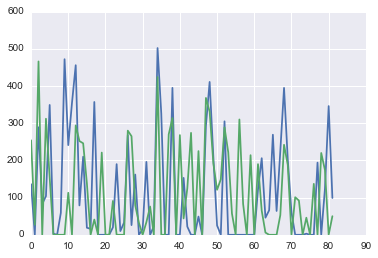

In [308]:
plt.plot(scores.fillna(0).groupby('team').get_group('MIA')[[4,-4]].as_matrix())

In [301]:
scores.fillna(0).groupby('team').get_group('GSW')

,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,team,win
33,0,0,0,0,339,213,0,0,161,240,330,0,0,0,GSW,1
37,0,0,0,234,235,341,133,92,53,351,240,0,0,0,GSW,0
78,0,0,0,101,156,0,0,0,291,0,0,0,0,0,GSW,1
94,0,0,0,105,75,477,0,133,115,0,0,0,0,0,GSW,1
132,0,0,0,570,254,285,0,26,433,246,0,0,0,0,GSW,1
163,0,0,0,16,110,43,0,0,26,0,143,0,0,0,GSW,0
181,0,0,0,0,411,216,103,1,0,103,462,0,0,0,GSW,0
216,0,0,0,200,0,87,46,0,422,0,526,0,0,0,GSW,1
246,0,0,0,120,55,151,0,242,0,0,0,0,0,0,GSW,1
289,0,0,0,179,104,0,0,0,0,135,0,0,0,0,GSW,1
